<a href="https://colab.research.google.com/github/Mateusz-best-creator/CelebritiesRecognition/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [183]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [184]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cuda


## Loading Data

In [185]:
import os

dataset_path = "/content/drive/MyDrive/celebrities_images"
count = 0
for root, dirs, files in os.walk(dataset_path):
  print(f"There are {len(dirs)} directories, {len(files)} image files in {root}")
  count += 1
  if count >= 10:
    break

There are 98 directories, 0 image files in /content/drive/MyDrive/celebrities_images
There are 0 directories, 50 image files in /content/drive/MyDrive/celebrities_images/Vin Diesel
There are 0 directories, 187 image files in /content/drive/MyDrive/celebrities_images/Sushant Singh Rajput
There are 0 directories, 196 image files in /content/drive/MyDrive/celebrities_images/Yami Gautam
There are 0 directories, 33 image files in /content/drive/MyDrive/celebrities_images/Sunny Deol
There are 0 directories, 41 image files in /content/drive/MyDrive/celebrities_images/Suniel Shetty
There are 0 directories, 46 image files in /content/drive/MyDrive/celebrities_images/Sonam Kapoor
There are 0 directories, 82 image files in /content/drive/MyDrive/celebrities_images/Tom Cruise
There are 0 directories, 88 image files in /content/drive/MyDrive/celebrities_images/Tom Holland
There are 0 directories, 81 image files in /content/drive/MyDrive/celebrities_images/Tom Hanks


In [186]:
import requests
from pathlib import Path

# Setup path to a data folder
image_path = Path("/content/drive/MyDrive/celebrities_images")

In [187]:
import random
from PIL import Image

# Get all image paths
image_path_list = list(image_path.glob("*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_2.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_17.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_22.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_14.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_21.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_13.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_1.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_19.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_11.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_18.jpg')]

Height = 1192 | Width = 1360


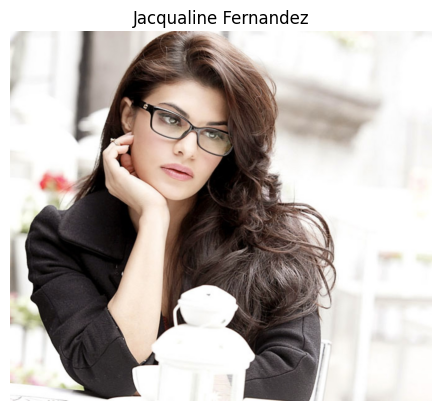

In [188]:
random_path = random.choice(image_path_list)
image_class = random_path.parent.stem
img = Image.open(random_path)

print(f"Height = {img.height} | Width = {img.width}")

plt.imshow(img)
plt.title(image_class)
plt.axis("off")
plt.show()

## Creating data transformations

In [189]:
from torchvision.transforms import v2

IMAGE_SIZE = 224
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

transformed_image = transforms(img)
transformed_image.shape

torch.Size([3, 224, 224])

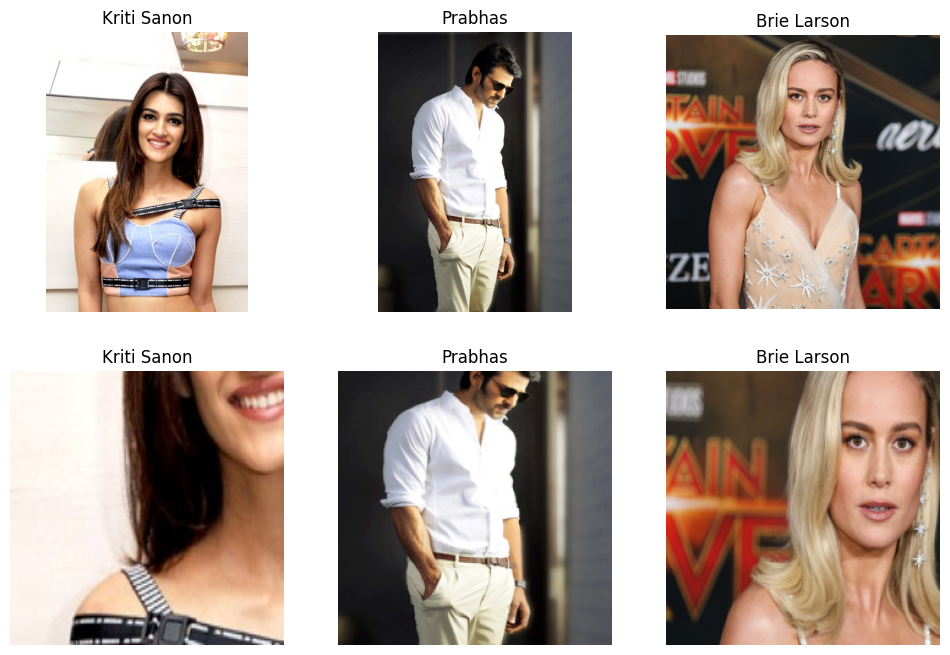

In [190]:
fig, ax = plt.subplots(nrows=2,
                       ncols=3,
                       figsize=(12, 8))

for col in range(3):

  random_path = random.choice(image_path_list)
  image_class = random_path.parent.stem
  img = Image.open(random_path)
  img_transformed = transforms(img).permute(1, 2, 0)

  for row in range(2):

    ax[row, col].set_title(image_class)
    if row == 0:
      ax[row, col].imshow(img)
    else:
      ax[row, col].imshow(img_transformed)
    ax[row, col].axis("off")

plt.show()

## Creating datasets using `ImageFolder`

In [191]:
import torchvision
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader, Subset

dataset = torchvision.datasets.ImageFolder(dataset_path)

def get_subset(indices, start, end):
    return indices[start : start + end]


TRAIN_PCT, VALIDATION_PCT = 0.7, 0.15  # rest will go for test
train_count = int(len(dataset) * TRAIN_PCT)
validation_count = int(len(dataset) * VALIDATION_PCT)
indices = torch.randperm(len(dataset))
train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len(dataset))

BATCH_SIZE = 32

class CustomTransformDataset(Dataset):

  def __init__(self,
               subset,
               transform):
    self.subset = subset
    self.transform = transform

  def __len__(self):
    return len(self.subset)

  def __getitem__(self, idx):
    s = self.subset[idx]
    if self.transform:
      s = self.transform(s)
    return s

def create_dataloaders(dataset_path,
                       batch_size=BATCH_SIZE,
                       train_proportion=0.7,
                       valid_proportion=0.15,
                       test_proportion=0.15,
                       train_transform=None,
                       test_valid_transform=None,
                       proportion=None):

  dataset = torchvision.datasets.ImageFolder(dataset_path)
  class_names = dataset.classes
  # Split indices
  TRAIN_PCT, VALIDATION_PCT = train_proportion, valid_proportion
  total = len(dataset)
  if proportion:
    assert proportion <= 1.0
    total = int(total*proportion)
  indices = torch.randperm(total).tolist()

  train_end = int(TRAIN_PCT * total)
  val_end = train_end + int(VALIDATION_PCT * total)

  train_indices = indices[:train_end]
  val_indices = indices[train_end:val_end]
  test_indices = indices[val_end:]

  train_subset = Subset(dataset, train_indices)
  val_subset = Subset(dataset, val_indices)
  test_subset = Subset(dataset, test_indices)

  train_dataset = CustomTransformDataset(train_subset, train_transform)
  val_dataset = CustomTransformDataset(val_subset, test_valid_transform)
  test_dataset = CustomTransformDataset(test_subset, test_valid_transform)

  BATCH_SIZE = 32
  return {
      "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
      "validation": DataLoader(val_dataset, batch_size=BATCH_SIZE),
      "test": DataLoader(test_dataset, batch_size=BATCH_SIZE)
  }, class_names


DATASET_PATH = "/content/drive/MyDrive/celebrities_images"
dataloaders, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH)
print(f'Lengths: Train = {len(dataloaders["train"])} | Validation = {len(dataloaders["validation"])} | Test = {len(dataloaders["test"])} | Batch Size = {BATCH_SIZE}')
dataloaders

Lengths: Train = 268 | Validation = 58 | Test = 58 | Batch Size = 32


{'train': <torch.utils.data.dataloader.DataLoader at 0x7bb67a082610>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7bb68e67a7d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7bb5f8810050>}

In [192]:
CLASS_NAMES[:10]

['Aamir Khan',
 'Abhay Deol',
 'Abhishek Bachchan',
 'Aishwarya Rai',
 'Ajay Devgn',
 'Akshay Kumar',
 'Akshaya Khanna',
 'Akshaye Khanna',
 'Alia Bhatt',
 'Amitabh Bachchan']

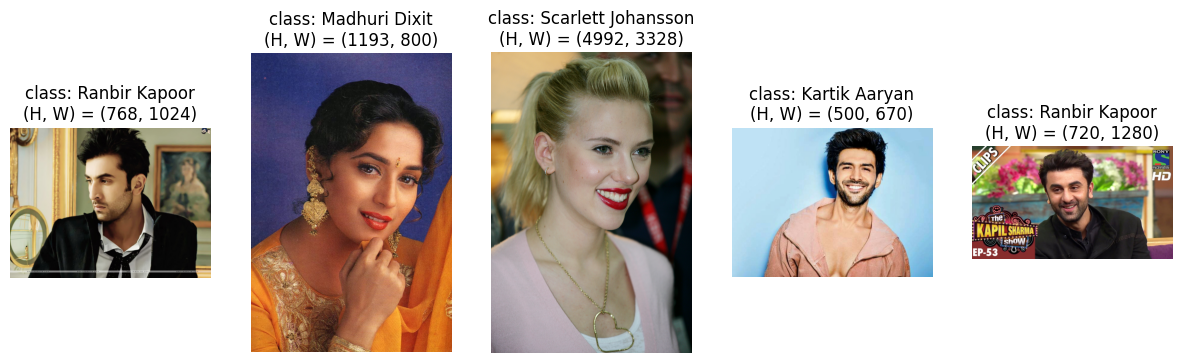

In [193]:
def display_random_images(dataset,
                          classes = None,
                          n = 10,
                          display_shape = True):

    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(15, 5))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\n(H, W) = ({targ_image.height}, {targ_image.width})"
        plt.title(title)

display_random_images(dataset, CLASS_NAMES, n=5)

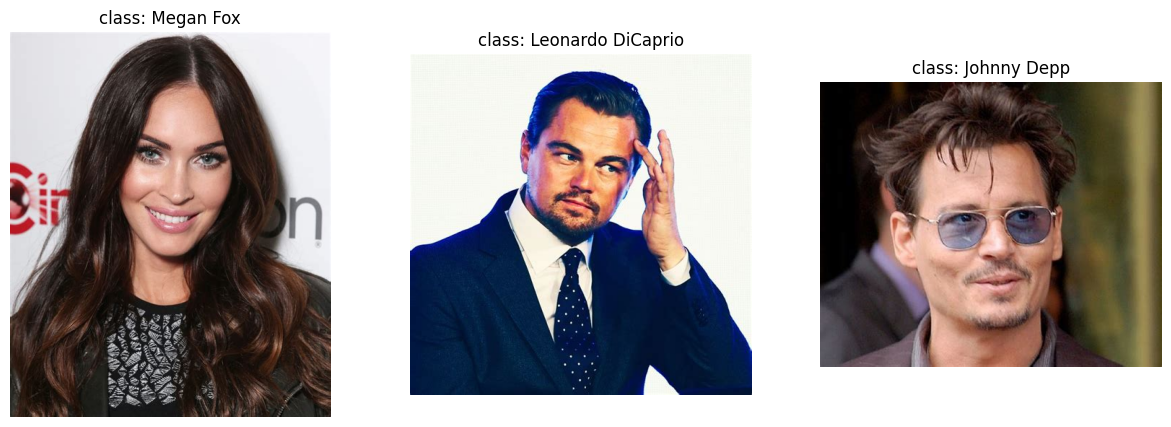

In [194]:
display_random_images(dataset, CLASS_NAMES, n=3, display_shape=False)

## Building TinyVGG model

In [195]:
simple_transform = v2.Compose([v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
                               v2.ToImage(),
                               v2.ToDtype(torch.float32, scale=True)])
dataloaders, CLASS_NAMES = create_dataloaders(DATASET_PATH,
                                              train_transform=simple_transform,
                                              test_valid_transform=simple_transform,
                                              proportion=0.2)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7bb68dc4bed0>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7bb67a3e6a10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7bb6b0d36110>}

224 -> 224 -> 112 -> 112 -> 112 -> 56 -> 56

In [196]:
class TinyVGG(nn.Module):

  def __init__(self,
               hidden_units,
               classifier_features=None):
    super(TinyVGG, self).__init__()
    self.sequential_1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.sequential_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 56 * 56, out_features=len(CLASS_NAMES)),
    )

  def forward(self, x):
    # print(x.shape)
    x = self.sequential_1(x)
    # print(x.shape)
    x = self.sequential_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

model_0 = TinyVGG(32).to(device)
model_0

TinyVGG(
  (sequential_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=98, bias=True)
  )
)

In [197]:
BASELINE_MODEL_NAME = "tinyVGG"
BASELINE_MODEL_PATH = f"/content/drive/MyDrive/celebrities_models/{BASELINE_MODEL_NAME}"
BASELINE_MODEL_PATH

'/content/drive/MyDrive/celebrities_models/tinyVGG'

In [198]:
train_dataloader_simple = dataloaders["train"]
img_batch, img_label = next(iter(train_dataloader_simple))

In [199]:
img = img_batch[0]
label = img_label[0]
img = img.unsqueeze(dim=0).to(device)
print(img.shape, label.shape)

with torch.inference_mode():
  logit = model_0(img)

print(f"Shape = {logit.shape}", logit)

torch.Size([1, 3, 224, 224]) torch.Size([])
Shape = torch.Size([1, 98]) tensor([[-0.0195, -0.0137, -0.0174,  0.0083,  0.0116,  0.0023, -0.0187, -0.0121,
          0.0006,  0.0059,  0.0096,  0.0149, -0.0257,  0.0038, -0.0023, -0.0050,
         -0.0201, -0.0016,  0.0039, -0.0176,  0.0014, -0.0026, -0.0024,  0.0097,
         -0.0007,  0.0123, -0.0011,  0.0086,  0.0155, -0.0091, -0.0058,  0.0093,
         -0.0101, -0.0120, -0.0076, -0.0050, -0.0078, -0.0037,  0.0043, -0.0004,
         -0.0154,  0.0066,  0.0030, -0.0052, -0.0144,  0.0038, -0.0146, -0.0210,
          0.0070,  0.0197,  0.0161, -0.0093, -0.0124, -0.0276, -0.0120,  0.0007,
         -0.0078,  0.0084, -0.0146, -0.0038,  0.0159,  0.0041,  0.0026,  0.0090,
         -0.0080,  0.0086, -0.0212, -0.0028, -0.0246, -0.0137,  0.0040, -0.0033,
         -0.0052,  0.0064, -0.0015,  0.0178, -0.0105, -0.0016, -0.0072, -0.0037,
          0.0128,  0.0299, -0.0031, -0.0089,  0.0182, -0.0221, -0.0208,  0.0065,
          0.0124,  0.0049,  0.0136,  

In [200]:
torch.nn.functional.softmax(logit, dim=1).max()

tensor(0.0105, device='cuda:0')

## Train and test loops

In [201]:
# !pip install tqdm

In [261]:
from tqdm import tqdm

def train_step(model,
               optimizer,
               loss_fn,
               train_dataloader,
               device,
               display_batch_info=False):
  model.train()
  model.to(device)
  train_loss = 0
  train_accuracy = 0

  # Loop through data
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    logits = model(X)
    loss = loss_fn(logits, y)
    preds = torch.nn.functional.softmax(logits, dim=1).argmax(dim=1)
    accuracy = (preds == y).sum().item() / len(y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Accumulate metrics
    train_loss += loss
    train_accuracy += accuracy

    if display_batch_info:
      if batch%30 == 0:
        print(f"witam w batchu: {batch}")

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)
  return train_loss, train_accuracy

def test_step(model,
              loss_fn,
              test_dataloader,
              device,
              display_batch_info=False):
  model.to(device)
  model.eval()
  test_accuracy = 0
  test_loss = 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      logits = model(X)
      test_loss += loss_fn(logits, y)
      preds = torch.nn.functional.softmax(logits, dim=1).argmax(dim=1)
      test_accuracy += (preds == y).sum().item() / len(y)

      if display_batch_info:
        if batch%30 == 0:
          print(f"witam w batchu testowym: {batch}")
    test_accuracy /= len(test_dataloader)
    test_loss /= len(test_dataloader)
  return test_loss, test_accuracy

EPOCHS = 10
def train(epochs,
          model,
          optimizer,
          loss_fn,
          train_dataloader,
          test_dataloader,
          device,
          display_batch_info=False):
  """
  Combines train_step and test_step functions and train and evaluate the model for given number of epochs.
  """

  # Create empty results dictionary
  results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train_step(model,
                                            optimizer,
                                            loss_fn,
                                            train_dataloader,
                                            device,
                                            display_batch_info)
    test_loss, test_accuracy = test_step(model,
                                         loss_fn,
                                         test_dataloader,
                                         device,
                                         display_batch_info)
    print()
    results["train_loss"].append(train_loss.item())
    results["train_acc"].append(train_accuracy)
    results["test_loss"].append(test_loss.item())
    results["test_acc"].append(test_accuracy)
    print(f"Epoch = {epoch}")
    print(f"Training = {train_loss:.4f} | {train_accuracy:.4f} | Testing = {test_loss:.4f} | {test_accuracy:.4f}")
  return results

### Training for 20% of the data

In [203]:
len(dataloaders["validation"])

12

In [204]:
len(dataloaders["train"])

54

In [205]:
try:
  baseline_m = TinyVGG(32).to(device)
  baseline_m.load_state_dict(torch.load(BASELINE_MODEL_PATH, weights_only=True))
except:
  optimizer_0 = torch.optim.Adam(params=model_0.parameters())
  loss_fn_0 = torch.nn.CrossEntropyLoss()

  print(f"Training on device: {device}")
  history_0 = train(10,
                    model_0,
                    optimizer_0,
                    loss_fn_0,
                    dataloaders["train"],
                    dataloaders["validation"],
                    device=device,
                    display_batch_info=False)

### Visualizaing Training Progress

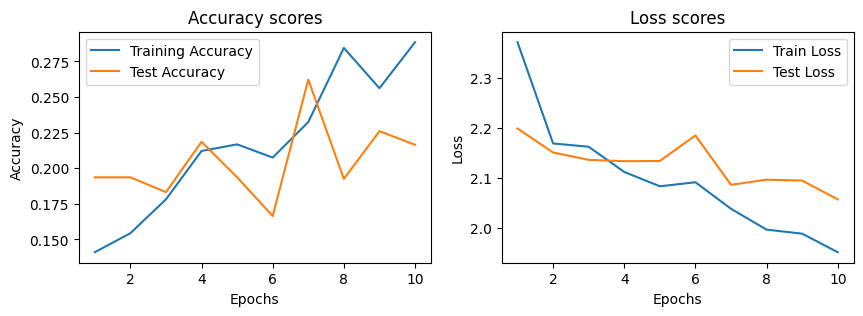

In [206]:
fig = plt.figure(figsize=(10, 3))
epochs = torch.arange(EPOCHS) + 1

# First subplot for accuracy
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, history_0["train_acc"], label="Training Accuracy")
ax1.plot(epochs, history_0["test_acc"], label="Test Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy scores")
ax1.legend()

# Second subplot for loss
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, history_0["train_loss"], label="Train Loss")
ax2.plot(epochs, history_0["test_loss"], label="Test Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss scores")
ax2.legend()

plt.show()

In [207]:
pd.DataFrame(history_0)

,train_loss,train_acc,test_loss,test_acc
0,2.371230,0.140993,2.198684,0.193614
1,2.168870,0.154356,2.150795,0.193614
2,2.162283,0.178136,2.136070,0.183197
3,2.111876,0.212121,2.133360,0.218524
4,2.083261,0.216751,2.133898,0.193614
5,2.091286,0.207492,2.184902,0.166440
6,2.038242,0.232428,2.086151,0.262228
7,1.996590,0.284512,2.096444,0.192482
8,1.988519,0.256208,2.094689,0.225996
9,1.951444,0.288510,2.057039,0.216486


## Function to predict on a custom image

In [324]:
def pred_and_plot_image(model,
                        image_path,
                        class_names=None,
                        transform=None,
                        device='cpu'):
    """Makes a prediction on a target image and plots:
    - the image with predicted label
    - a bar chart of the top 10 class predictions
    """
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
    if transform:
        target_image = transform(target_image)
    model.to(device)

    model.eval()
    with torch.inference_mode():
        input_image = target_image.unsqueeze(0).to(device)
        output = model(input_image)

    probs = torch.softmax(output, dim=1).squeeze()
    pred_idx = torch.argmax(probs).item()
    pred_conf = probs[pred_idx].item()

    top_10_idx = torch.topk(probs, k=10).indices.cpu().numpy()
    top_10_values = [probs[i].item() for i in top_10_idx]
    top_10_classes = [class_names[i] for i in top_10_idx] if class_names else [str(i) for i in top_10_idx]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(Image.open(image_path))
    pred_label = class_names[pred_idx] if class_names else str(pred_idx)
    ax[0].set_title(f"Predicted: {pred_label}\nConfidence: {pred_conf:.2f}")
    ax[0].axis("off")

    ax[1].barh(top_10_classes, top_10_values, edgecolor='black')
    ax[1].set_xlabel("Confidence")
    ax[1].set_title("Top 10 Predictions")
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

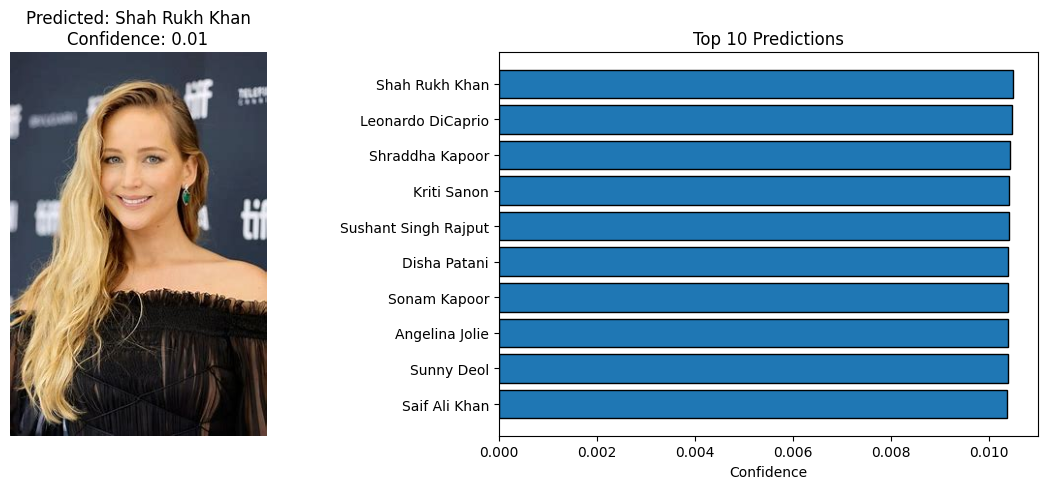

In [325]:
pred_and_plot_image(model_0,
                    "/content/drive/MyDrive/jl.jpg",
                    CLASS_NAMES,
                    simple_transform,
                    device)

### Saving baseline Model

In [210]:
torch.save(model_0.state_dict(), BASELINE_MODEL_PATH)

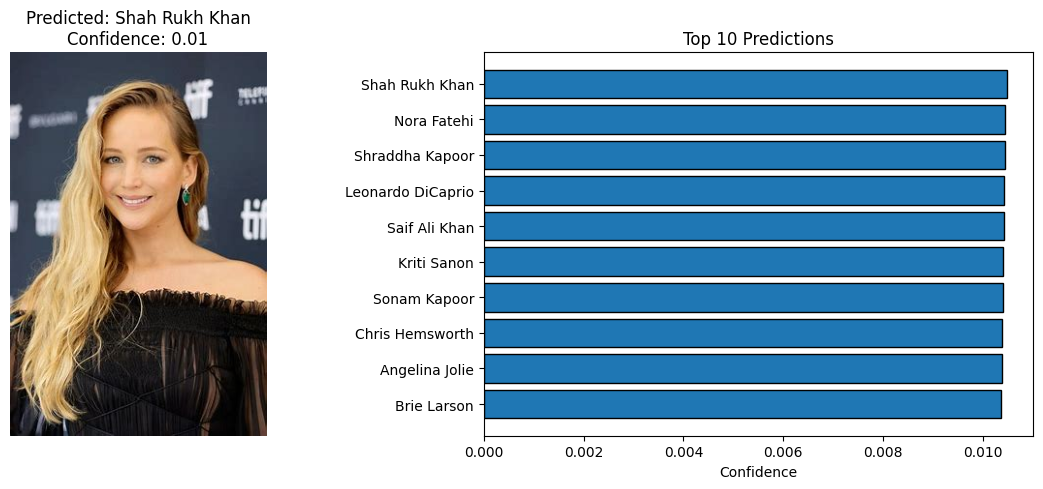

In [326]:
baseline_m = TinyVGG(32).to(device)
baseline_m.load_state_dict(torch.load(BASELINE_MODEL_PATH, weights_only=True))

pred_and_plot_image(baseline_m,
                    "/content/drive/MyDrive/jl.jpg",
                    CLASS_NAMES,
                    simple_transform,
                    device)

## Trying EfficientNet B0

In [219]:
from torchvision.models import efficientnet_b0

# Get pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available
auto_transforms = weights.transforms()
auto_transforms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

auto_transforms

Compose(
      Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(224, 224))
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [220]:
DATASET_PATH

'/content/drive/MyDrive/celebrities_images'

In [234]:
effn_dataloaders, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH,
                                                  train_transform=auto_transforms,
                                                  test_valid_transform=auto_transforms,
                                                   proportion=0.1)
effn_dataloaders, CLASS_NAMES[:10]

({'train': <torch.utils.data.dataloader.DataLoader at 0x7bb5f6f66fd0>,
  'validation': <torch.utils.data.dataloader.DataLoader at 0x7bb5f6f67050>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7bb5f6f67250>},
 ['Aamir Khan',
  'Abhay Deol',
  'Abhishek Bachchan',
  'Aishwarya Rai',
  'Ajay Devgn',
  'Akshay Kumar',
  'Akshaya Khanna',
  'Akshaye Khanna',
  'Alia Bhatt',
  'Amitabh Bachchan'])

In [235]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7bb68dc4bed0>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7bb67a3e6a10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7bb6b0d36110>}

In [236]:
len(effn_dataloaders["train"])

27

In [237]:
img_batch, img_label = next(iter(dataloaders["train"]))

In [238]:
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
eff_net_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
eff_net_model.features[:2], eff_net_model.avgpool, eff_net_model.classifier

(Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): SiLU(inplace=True)
   )
   (1): Sequential(
     (0): MBConv(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): SiLU(inplace=True)
         )
         (1): SqueezeExcitation(
           (avgpool): AdaptiveAvgPool2d(output_size=1)
           (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
           (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
           (activation): SiLU(inplace=True)
           (scale_activation): Sigmoid()
         )
         (2): Conv2dNormActivation(
           (0): Conv2d(32, 16, kernel_size=

In [239]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [240]:
# Freeze model parameters
for param in eff_net_model.features.parameters():
  param.requires_grad = False

eff_net_model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                         nn.Linear(in_features=1280, out_features=len(CLASS_NAMES)))

summary(eff_net_model,
        input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 98]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

In [241]:
eff_net_loss_fn = nn.CrossEntropyLoss()
eff_net_optimizer = torch.optim.Adam(eff_net_model.parameters())
EFFICIENT_NET_MODEL_PATH = f"/content/drive/MyDrive/celebrities_models/efficient_net_B0"

try:
  eff_net_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
  eff_net_model.load_state_dict(torch.load(EFFICIENT_NET_MODEL_PATH, weights_only=True))
except:
  EPOCHS=10
  effnet_history = train(epochs=10,
                        model=eff_net_model,
                        optimizer=eff_net_optimizer,
                        loss_fn=eff_net_loss_fn,
                        train_dataloader=effn_dataloaders["train"],
                        test_dataloader=effn_dataloaders["validation"],
                        device=device,
                        display_batch_info=False)

 10%|█         | 1/10 [00:20<03:06, 20.70s/it]


Epoch = 0
Training = 2.7060 | 0.2773 | Testing = 1.9534 | 0.3766


 20%|██        | 2/10 [00:40<02:40, 20.08s/it]


Epoch = 1
Training = 1.6890 | 0.4659 | Testing = 1.6668 | 0.5285


 30%|███       | 3/10 [01:02<02:26, 20.87s/it]


Epoch = 2
Training = 1.4484 | 0.6074 | Testing = 1.5070 | 0.5306


 40%|████      | 4/10 [01:25<02:11, 21.95s/it]


Epoch = 3
Training = 1.2707 | 0.6470 | Testing = 1.3947 | 0.5754


 50%|█████     | 5/10 [01:46<01:46, 21.38s/it]


Epoch = 4
Training = 1.1418 | 0.7041 | Testing = 1.3418 | 0.5630


 60%|██████    | 6/10 [02:07<01:25, 21.37s/it]


Epoch = 5
Training = 1.0348 | 0.7318 | Testing = 1.2956 | 0.5786


 70%|███████   | 7/10 [02:27<01:03, 21.03s/it]


Epoch = 6
Training = 0.9828 | 0.7503 | Testing = 1.2625 | 0.5754


 80%|████████  | 8/10 [02:49<00:42, 21.10s/it]


Epoch = 7
Training = 0.9219 | 0.7598 | Testing = 1.2294 | 0.5806


 90%|█████████ | 9/10 [03:09<00:20, 20.74s/it]


Epoch = 8
Training = 0.8770 | 0.7791 | Testing = 1.1799 | 0.5962


100%|██████████| 10/10 [03:29<00:00, 20.96s/it]


Epoch = 9
Training = 0.8081 | 0.7960 | Testing = 1.1748 | 0.5942


### Save EfficientNet B0

In [246]:
torch.save(eff_net_model.state_dict(), EFFICIENT_NET_MODEL_PATH)

## Training EfficientNetBo on 50% of the dataset

In [264]:
effn_dataloaders_all, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH,
                                                      train_transform=auto_transforms,
                                                      test_valid_transform=auto_transforms,
                                                       proportion=0.5)
effn_dataloaders_all, CLASS_NAMES[:10]

({'train': <torch.utils.data.dataloader.DataLoader at 0x7bb5f67d1cd0>,
  'validation': <torch.utils.data.dataloader.DataLoader at 0x7bb5f6ada7d0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7bb5f67d1d90>},
 ['Aamir Khan',
  'Abhay Deol',
  'Abhishek Bachchan',
  'Aishwarya Rai',
  'Ajay Devgn',
  'Akshay Kumar',
  'Akshaya Khanna',
  'Akshaye Khanna',
  'Alia Bhatt',
  'Amitabh Bachchan'])

In [265]:
len(effn_dataloaders_all["train"])

134

In [266]:
eff_net_model_all = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
for param in eff_net_model_all.features.parameters():
  param.requires_grad = False

eff_net_model_all.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                             nn.Linear(in_features=1280, out_features=len(CLASS_NAMES)))

In [267]:
eff_net_loss_fn_all = nn.CrossEntropyLoss()
eff_net_optimizer_all = torch.optim.Adam(eff_net_model_all.parameters())
EFFICIENT_NET_MODEL_PATH_ALL = f"/content/drive/MyDrive/celebrities_models/efficient_net_B0_all_dataset"

In [269]:
EPOCHS=10
effnet_all_history = train(epochs=10,
                      model=eff_net_model_all,
                      optimizer=eff_net_optimizer_all,
                      loss_fn=eff_net_loss_fn_all,
                      train_dataloader=effn_dataloaders_all["train"],
                      test_dataloader=effn_dataloaders_all["validation"],
                      device=device,
                      display_batch_info=True)

  0%|          | 0/10 [00:00<?, ?it/s]

witam w batchu: 0


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 10%|█         | 1/10 [15:44<2:21:36, 944.11s/it]


Epoch = 0
Training = 2.9112 | 0.2792 | Testing = 2.6065 | 0.3226
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 20%|██        | 2/10 [17:31<1:00:16, 452.03s/it]


Epoch = 1
Training = 2.3079 | 0.4373 | Testing = 2.3145 | 0.4004
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 30%|███       | 3/10 [19:21<34:29, 295.63s/it]  


Epoch = 2
Training = 1.9753 | 0.5153 | Testing = 2.1589 | 0.4248
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 40%|████      | 4/10 [21:12<22:17, 222.90s/it]


Epoch = 3
Training = 1.7725 | 0.5630 | Testing = 2.0477 | 0.4459
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 50%|█████     | 5/10 [23:05<15:16, 183.20s/it]


Epoch = 4
Training = 1.5924 | 0.6140 | Testing = 1.9891 | 0.4595
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 60%|██████    | 6/10 [24:57<10:35, 158.93s/it]


Epoch = 5
Training = 1.4852 | 0.6368 | Testing = 1.9616 | 0.4524
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 70%|███████   | 7/10 [26:47<07:09, 143.01s/it]


Epoch = 6
Training = 1.3803 | 0.6653 | Testing = 1.9172 | 0.4591
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 80%|████████  | 8/10 [28:37<04:25, 132.61s/it]


Epoch = 7
Training = 1.2974 | 0.6843 | Testing = 1.8953 | 0.4629
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


 90%|█████████ | 9/10 [30:27<02:05, 125.55s/it]


Epoch = 8
Training = 1.2392 | 0.6893 | Testing = 1.8783 | 0.4761
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu testowym: 0


100%|██████████| 10/10 [32:19<00:00, 193.91s/it]


Epoch = 9
Training = 1.1906 | 0.6918 | Testing = 1.8506 | 0.4718


In [270]:
torch.save(eff_net_model_all.state_dict(), EFFICIENT_NET_MODEL_PATH_ALL)

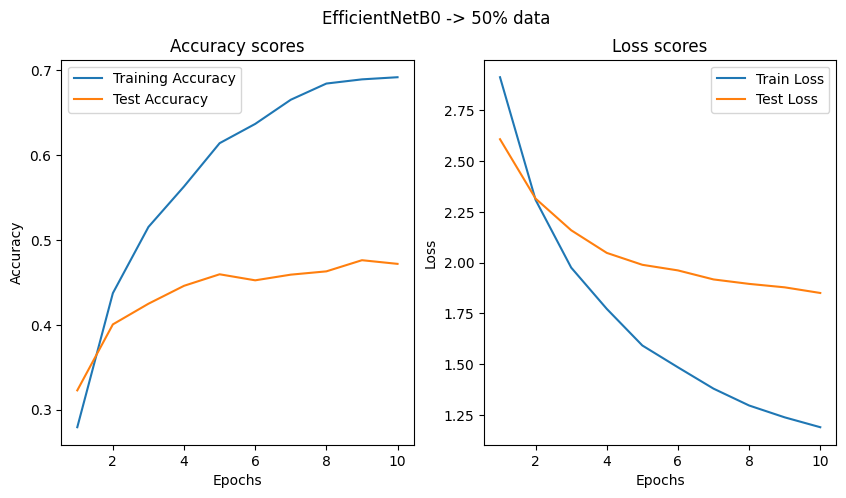

In [284]:
def plot_training(history, epochs, title):
  fig = plt.figure(figsize=(10, 5))
  epochs = torch.arange(epochs) + 1
  fig.suptitle(title)

  # First subplot for accuracy
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, history["train_acc"], label="Training Accuracy")
  ax1.plot(epochs, history["test_acc"], label="Test Accuracy")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Accuracy")
  ax1.set_title("Accuracy scores")
  ax1.legend()

  # Second subplot for loss
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, history["train_loss"], label="Train Loss")
  ax2.plot(epochs, history["test_loss"], label="Test Loss")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Loss")
  ax2.set_title("Loss scores")
  ax2.legend()

  plt.show()

plot_training(effnet_all_history, 10, "EfficientNetB0 -> 50% data")

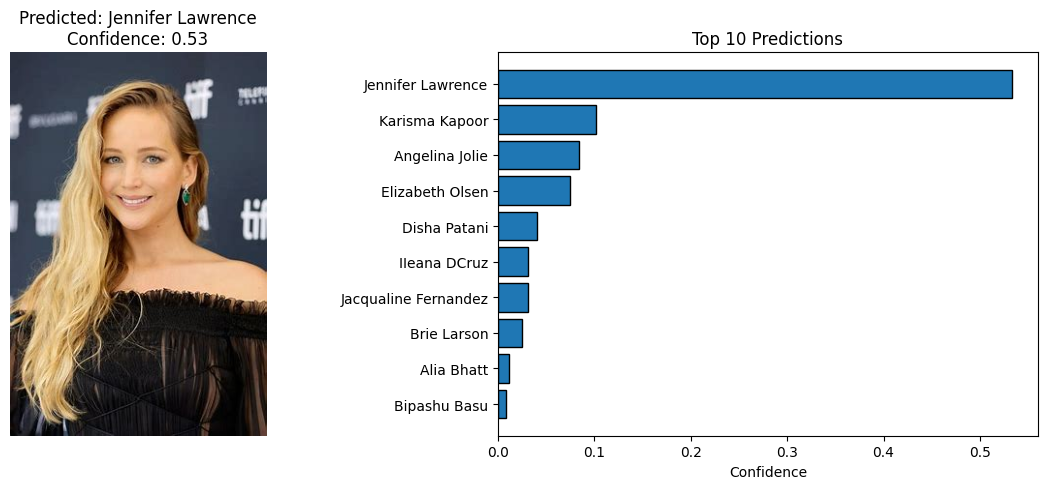

In [327]:
pred_and_plot_image(eff_net_model_all,
                    "/content/drive/MyDrive/jl.jpg",
                    CLASS_NAMES,
                    auto_transforms,
                    device)

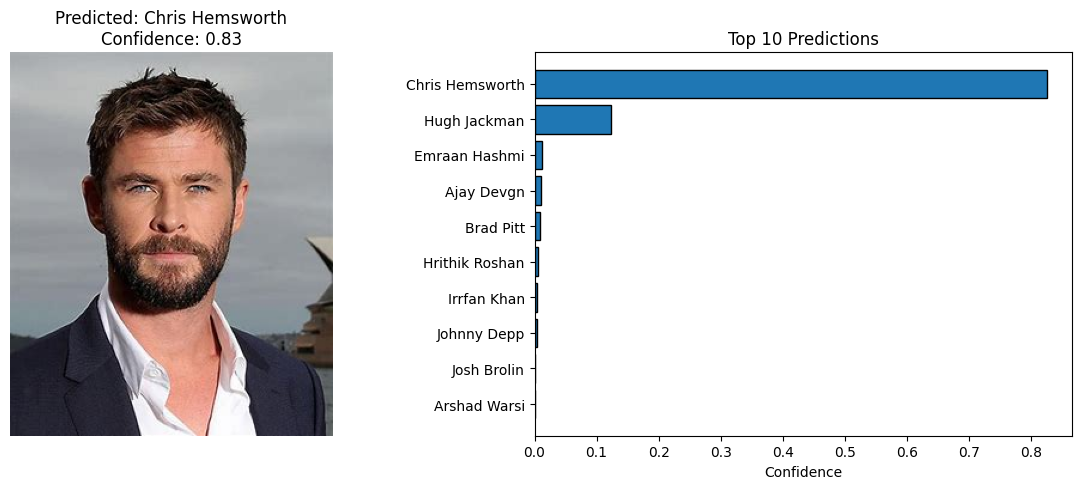

In [328]:
pred_and_plot_image(eff_net_model_all,
                    "/content/drive/MyDrive/chris.jpg",
                    CLASS_NAMES,
                    auto_transforms,
                    device)